# 某国际电商平台用户支付转化分析

## 1. 明确项目背景和需求
### 1.1 项目背景
1. 某国际电商（APP和网站）的GMV持续下降   
2. 设定原因为用户下单转化率（CR）下降导致的GMV下降  
3. **下单转化漏斗：**   $首页\Rightarrow产品列表页\Rightarrow产品详情页\Rightarrow订单结算页\Rightarrow支付完成确认页$   
   **下单转化率计算公式：** $CR = \frac {支付成功人数}{进入首页人数}$   
   *注：转化率基于页面跳转*   

### 1.2 项目需求
1. 为产品团队和运营团队或开发团队提出建议，以提高下单转化率    
2. 建立一个预测用户下单转化模型

## 2. 探索数据集（EDA）

### 2.1 数据集信息
项目一共有6个数据集(某一段时间内的用户数据):   
1. user_table: 用户信息   
2. home_page_table: 浏览过主页的用户   
3. listing_page_table: 浏览过列表页的用户   
4. product_page_table: 浏览过产品详情页的用户   
5. payment_page_table: 浏览过支付结算页的用户   
6. payment_confirmation_page_table: 浏览过支付完成确认页的用户

### 2.2 载入数据处理所需库

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#plt中文显示问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

### 2.3 载入数据

In [39]:
# user_table: 用户信息
user_info = pd.read_csv('user_table_1.csv')
user_info.head()

,user_id,new_user,age,sex,country,source,total_pages_visited
0,654951,0,17,Female,US,Direct,3
1,730619,0,27,Male,UK,Direct,5
2,261033,0,24,Female,US,Seo,4
3,533685,0,21,Male,UK,Direct,5
4,699480,0,17,Male,UK,Direct,6


**字段解读：**  
- user_id: 用户ID*（唯一）   
- new_user: 是否是新用户，是1，不是0   
- age: 用户年龄   
- sex: 用户性别   
- country: 用户所属国家   
- operative_system: 操作系统，mobile（ios、android），desktop（mac、windows、linux）   
- source: 用户来源，直接Direct，Seo搜索引擎，Ads广告   
- total_pages_visited: 浏览页面总数   

In [40]:
user_info.shape

(90400, 7)

In [41]:
# home_page_table: 浏览过主页的用户
user_home = pd.read_csv('home_page_table.csv')
user_home.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [42]:
user_home.shape

(90400, 2)

In [43]:
# listing_page_table: 浏览过列表页的用户
user_listing = pd.read_csv('listing_page_table.csv')
user_listing.head()

,user_id,page
0,313593,listing_page
1,468315,listing_page
2,264005,listing_page
3,290784,listing_page
4,262889,listing_page


In [44]:
user_listing.shape

(66392, 2)

In [45]:
# product_page_table: 浏览过产品详情页的用户
user_product = pd.read_csv('product_page_table.csv')
user_product.head()

,user_id,page
0,15866,product_page
1,347058,product_page
2,577020,product_page
3,780347,product_page
4,383739,product_page


In [46]:
user_product.shape

(45200, 2)

In [47]:
# payment_page_table: 浏览过支付结算页的用户
user_payment = pd.read_csv('payment_page_table.csv')
user_payment.head()

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [48]:
user_payment.shape

(6030, 2)

In [49]:
# payment_confirmation_page_table: 浏览过支付完成确认页的用户
user_confirmation = pd.read_csv('payment_confirmation_table.csv')
user_confirmation.head()

,user_id,page
0,253019,payment_confirmation_page
1,310478,payment_confirmation_page
2,304081,payment_confirmation_page
3,901286,payment_confirmation_page
4,266323,payment_confirmation_page


In [50]:
user_confirmation.shape

(1994, 2)

### 2.4 数据预览

In [51]:
# describe()查看数据的各统计量，主要了解数据范围及对异常值初步判断
user_info.describe()

,user_id,new_user,age,total_pages_visited
count,90400.000000,90400.000000,90400.000000,90400.000000
mean,498709.683473,0.308374,30.440796,5.418097
std,289040.674085,0.461824,8.224111,3.682882
min,17.000000,0.000000,17.000000,1.000000
25%,247978.750000,0.000000,24.000000,3.000000
50%,498267.000000,0.000000,30.000000,4.000000
75%,749789.250000,1.000000,36.000000,7.000000
max,999979.000000,1.000000,123.000000,28.000000


In [52]:
# info()查看数据类型，是否有缺失值
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              90400 non-null  int64 
 1   new_user             90400 non-null  int64 
 2   age                  90400 non-null  int64 
 3   sex                  89627 non-null  object
 4   country              90339 non-null  object
 5   source               90277 non-null  object
 6   total_pages_visited  90400 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 4.8+ MB


### 2.5 数据可视化探索

#### 2.5.1 new_user

In [53]:
# '是否为新用户'的标签数量
user_info['new_user'].nunique()

2

In [54]:
# '是否为新用户'的标签内容：1-新，0-老
user_info['new_user'].unique()

array([0, 1], dtype=int64)

In [55]:
# 按新老用户分组计算各自的数量
user_info['new_user'].value_counts()

0    62523
1    27877
Name: new_user, dtype: int64

[Text(0, 0, '27877'), Text(0, 0, '62523')]

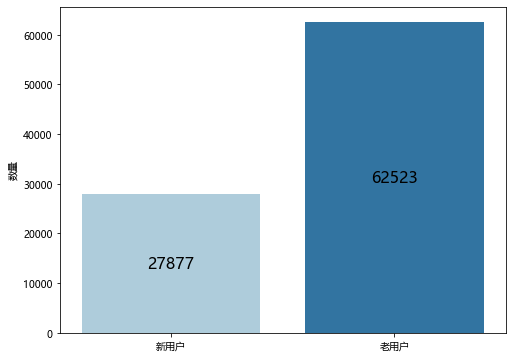

In [56]:
# 计算新老用户人数 user_info[user_info['new_user']==1]['user_id'].nunique()
new_user_num = user_info['new_user'].value_counts()[1]
old_user_num = user_info['new_user'].value_counts()[0]
# 画新老用户直方图 - 看数量
x = ['新用户','老用户']
y = [new_user_num,old_user_num]
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.set_palette('Paired')
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

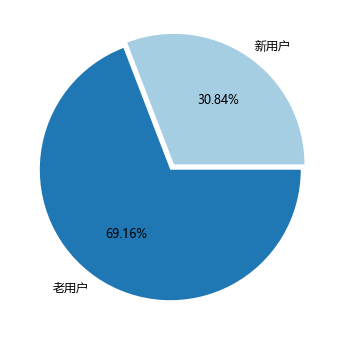

In [57]:
# 画新老用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0.05,0])
plt.show()

#### 2.5.2 age

In [58]:
# 查看用户年龄并排序，初步判断109、123为异常值
print(sorted(user_info['age'].unique()))

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 109, 123]


<AxesSubplot:xlabel='age', ylabel='Density'>

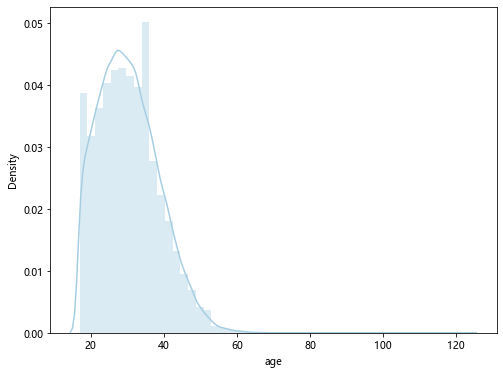

In [59]:
# 年龄为连续性变量，可以用直方图展示
plt.figure(figsize=(8,6)) 
sns.distplot(user_info['age'])

#### 2.5.3 sex

In [60]:
# 性别的标签数量
user_info['sex'].nunique()

2

In [61]:
# 性别的标签内容
user_info['sex'].unique()

array(['Female', 'Male', nan], dtype=object)

In [62]:
# 按性别分组计算各自的数量
user_info['sex'].value_counts()

Female    54899
Male      34728
Name: sex, dtype: int64

[Text(0, 0, '54899'), Text(0, 0, '34728')]

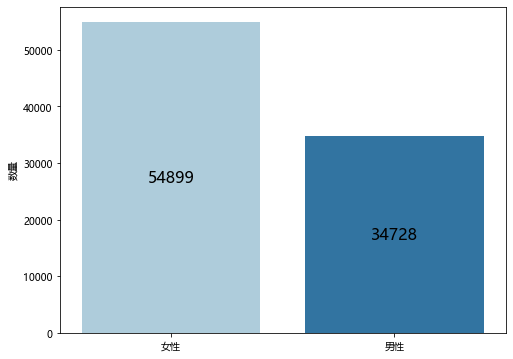

In [63]:
# 计算男女用户人数
female_num = user_info['sex'].value_counts()[0]
male_num = user_info['sex'].value_counts()[1]
# 画男女用户直方图 - 看数量
x = ['女性','男性']
y = [female_num,male_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

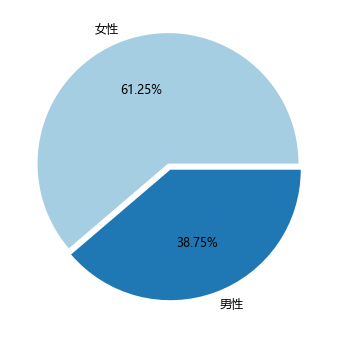

In [64]:
# 画男女用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0.05,0])
plt.show()

#### 2.5.4 country

In [65]:
# 国家的标签数量
user_info['country'].nunique()

4

In [66]:
# 国家的标签内容
user_info['country'].unique()

array(['US', 'UK', 'Germany', 'China', nan], dtype=object)

In [67]:
# 按性别分组计算各自的数量
user_info['country'].value_counts()

US         53347
China      16563
UK         15402
Germany     5027
Name: country, dtype: int64

[Text(0, 0, '53347'),
 Text(0, 0, '16563'),
 Text(0, 0, '15402'),
 Text(0, 0, '5027')]

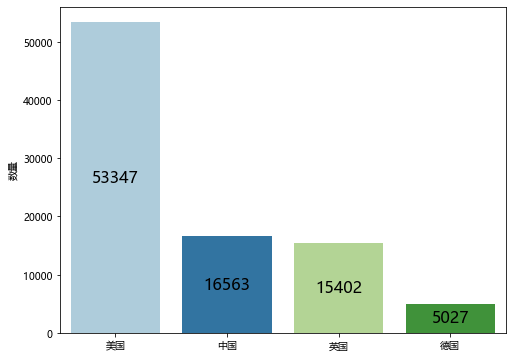

In [68]:
# 计算各国家用户人数 
us_num = user_info['country'].value_counts()[0]
china_num = user_info['country'].value_counts()[1]
uk_num = user_info['country'].value_counts()[2]
germany_num = user_info['country'].value_counts()[3]
# 画各国家用户直方图 - 看数量
x = ['美国','中国','英国','德国']
y = [us_num,china_num,uk_num,germany_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

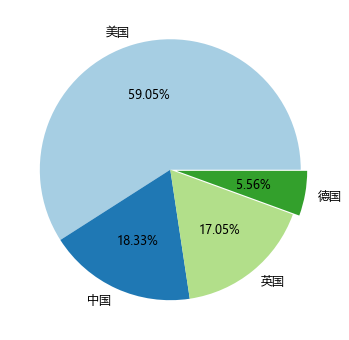

In [69]:
# 画各国家用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0,0,0.05])
plt.show()

#### 2.5.7 source

In [70]:
# 用户来源的标签数量
user_info['source'].nunique()

3

In [71]:
# 用户来源的标签内容
user_info['source'].unique()

array(['Direct', 'Seo', 'Ads', nan], dtype=object)

In [72]:
# 按用户来源分组计算各自的数量
user_info['source'].value_counts()

Direct    51886
Seo       25018
Ads       13373
Name: source, dtype: int64

[Text(0, 0, '51886'), Text(0, 0, '25018'), Text(0, 0, '13373')]

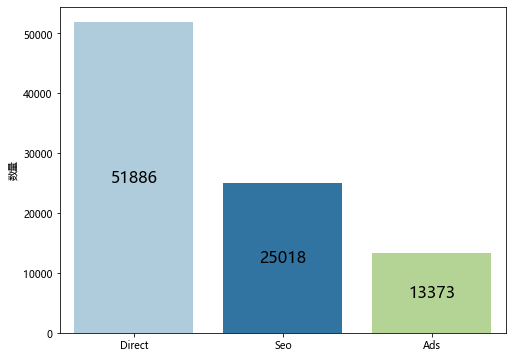

In [73]:
# 计算各用户来源用户人数 
direct_num = user_info['source'].value_counts()[0]
seo_num = user_info['source'].value_counts()[1]
ads_num = user_info['source'].value_counts()[2]
# 画各用户来源用户直方图 - 看数量
x = ['Direct','Seo','Ads']
y = [direct_num,seo_num,ads_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

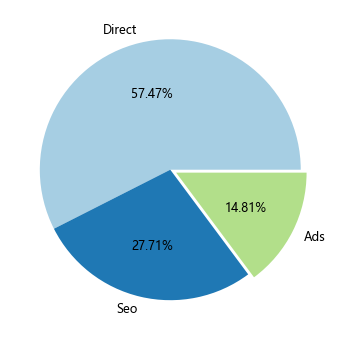

In [74]:
# 画各用户来源用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0,0.05])
plt.show()

#### 2.5.8 total_pages_visited

In [75]:
# 总浏览页面数的标签内容
user_info['total_pages_visited'].unique()

array([ 3,  5,  4,  6,  2,  8,  7,  9, 14, 10, 11,  1, 18, 15, 19, 12, 13,
       21, 17, 20, 23, 16, 25, 26, 24, 22, 27, 28], dtype=int64)

<AxesSubplot:xlabel='total_pages_visited', ylabel='Density'>

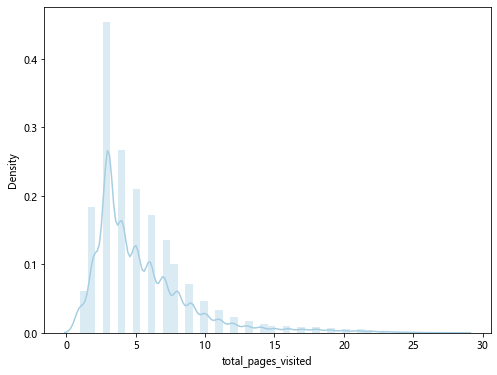

In [76]:
# 画总浏览页面数直方图
plt.figure(figsize=(8,6)) 
sns.distplot(user_info['total_pages_visited'])

### 2.6 数据处理

针对异常值、缺失值进行处理

#### 2.6.1 异常值

异常值主要针对数值型变量age, total_pages_visited, new_user 其中new_user实则为分类型变量，因此异常值仅针对age和total_page_visited去查找

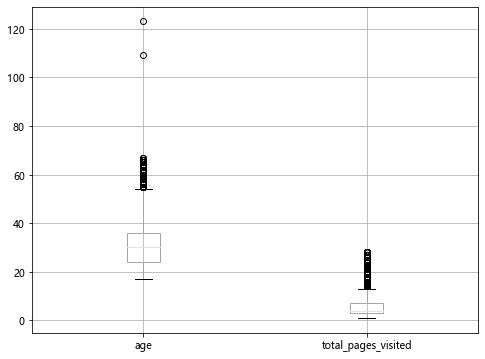

In [77]:
#age和total_pages_visited的箱型图
plt.figure(figsize=(8,6)) 
boxplot = user_info.boxplot(column = ['age','total_pages_visited'])

异常值的处理要结合实际数据来，在箱线图中显示异常的值不一定真的不合理

In [78]:
#查看age的异常值是否合理
user_info['age'].max()

123

In [79]:
print(sorted(user_info['age'].unique(),reverse = True))

[123, 109, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [80]:
#删除两个异常值
user_info = user_info[user_info['age']<100]

#### 2.6.2 缺失值

填补缺失值的办法：
- 删除法：如果缺失值比例较低，可以直接删除
- 根据数据分布： 填入众数、平均数、中位数
- 建模

In [81]:
#查看缺失值个数
user_info.isnull().sum()

user_id                  0
new_user                 0
age                      0
sex                    773
country                 61
source                 123
total_pages_visited      0
dtype: int64

一般从缺失值较少的那一列开始

##### 2.6.2.1 缺失值country
- 因为缺失值较少，因此可以直接删除或直接填入众数

In [82]:
user_info['country'].mode()[0]

'US'

In [83]:
user_info['country'].fillna(user_info['country'].mode()[0],inplace = True)

In [84]:
user_info.isnull().sum()

user_id                  0
new_user                 0
age                      0
sex                    773
country                  0
source                 123
total_pages_visited      0
dtype: int64

##### 2.6.2.2 缺失值source
- 因为缺失值较少，可以直接删除或直接填入众数
- 根据其他已知数据的分布来填补
- source猜想跟new_user有关

In [85]:
#创建一个没有缺失值的新数据去看规律

#dropna()默认为axis = 0：删除含有缺失值的每行数据，axis = 1：删除含有缺失值的每列数据
user_full = user_info.dropna()

In [90]:
user_full.groupby(['new_user','source'])['user_id'].count()

new_user  source
0         Ads        4373
          Direct    49226
          Seo        8308
1         Ads        8869
          Direct     2236
          Seo       16490
Name: user_id, dtype: int64

发现：老用户主要来源于direct，而新用户主要来源于Seo

In [91]:
# 当用户为新用户，source缺失值填补Seo
user_info['source'] = np.where((user_info['source'].isnull())&(user_info['new_user']==1),'Seo',user_info['source'])

In [92]:
#当用户为老用户，source缺失值填补Direct
user_info['source'].fillna('Direct',inplace = True)

In [93]:
user_info.isnull().sum()

user_id                  0
new_user                 0
age                      0
sex                    773
country                  0
source                   0
total_pages_visited      0
dtype: int64

##### 2.6.2.5 缺失值sex

In [94]:
user_info['sex'].mode()[0]

'Female'

In [95]:
user_info['sex'].fillna(user_info['sex'].mode()[0],inplace = True)

In [96]:
user_info.isnull().sum()

user_id                0
new_user               0
age                    0
sex                    0
country                0
source                 0
total_pages_visited    0
dtype: int64

In [97]:
user_info.shape

(90398, 7)

### （补）数据处理后的可视化探索

**1.new_user**

[Text(0, 0, '27877'), Text(0, 0, '62521')]

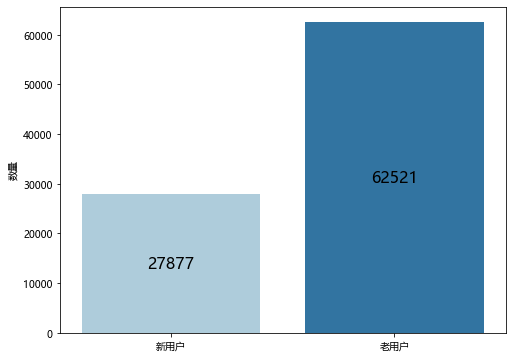

In [98]:
# 计算新老用户人数 user_info[user_info['new_user']==1]['user_id'].nunique()
new_user_num = user_info['new_user'].value_counts()[1]
old_user_num = user_info['new_user'].value_counts()[0]
# 画新老用户直方图 - 看数量
x = ['新用户','老用户']
y = [new_user_num,old_user_num]
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.set_palette('Paired')
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

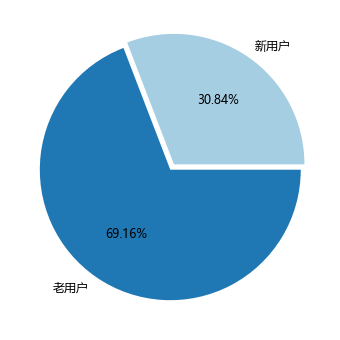

In [99]:
# 画新老用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0.05,0])
plt.show()

**2.age**

<AxesSubplot:xlabel='age', ylabel='Density'>

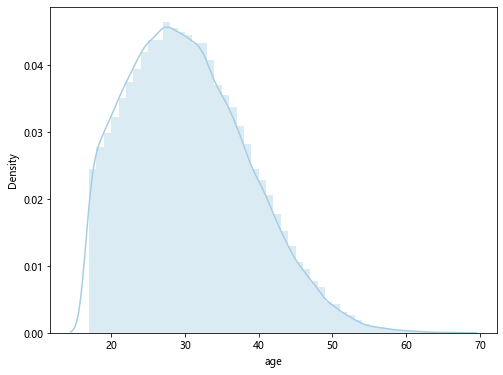

In [100]:
# 年龄为连续性变量，可以用直方图展示
plt.figure(figsize=(8,6)) 
sns.distplot(user_info['age'])

In [101]:
#为了不改变原来的数据，深拷贝一个user_info_1
user_info_1 = user_info.copy(deep=True)

In [102]:
#查看年龄-从17岁67岁
print(sorted(user_info_1['age'].unique()))

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


打算分为5个年龄阶段：[17,25],[26-35],[36,45],[46,55],[56-67]

In [103]:
user_info_1.loc[(user_info_1.age>=17)&(user_info_1.age<=25),'age_group'] = '[17,25]'
user_info_1.loc[(user_info_1.age>=26)&(user_info_1.age<=35),'age_group'] = '[26,35]'
user_info_1.loc[(user_info_1.age>=36)&(user_info_1.age<=45),'age_group'] = '[36,45]'
user_info_1.loc[(user_info_1.age>=46)&(user_info_1.age<=55),'age_group'] = '[46,55]'
user_info_1.loc[(user_info_1.age>=56)&(user_info_1.age<=67),'age_group'] = '[56,67]'

In [104]:
#查看各年龄段
print(sorted(user_info_1['age_group'].unique()))

['[17,25]', '[26,35]', '[36,45]', '[46,55]', '[56,67]']


In [105]:
user_info_1['age_group'].value_counts()

[26,35]    38404
[17,25]    28182
[36,45]    19598
[46,55]     3901
[56,67]      313
Name: age_group, dtype: int64

[Text(0, 0, '28182'),
 Text(0, 0, '38404'),
 Text(0, 0, '19598'),
 Text(0, 0, '3901'),
 Text(0, 0, '313')]

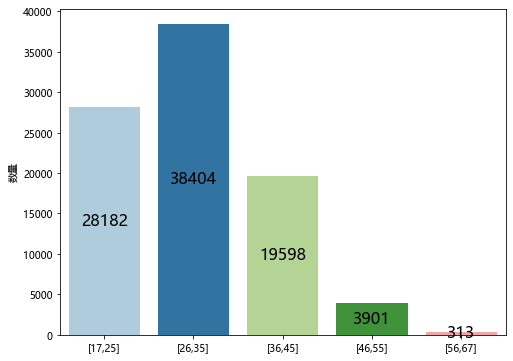

In [106]:
# 计算各年龄段用户人数
age_1725_num = user_info_1['age_group'].value_counts()[1]
age_2635_num = user_info_1['age_group'].value_counts()[0]
age_3645_num = user_info_1['age_group'].value_counts()[2]
age_4655_num = user_info_1['age_group'].value_counts()[3]
age_5667_num = user_info_1['age_group'].value_counts()[4]
# 画各年龄段用户人数直方图 - 看数量
x = ['[17,25]','[26,35]','[36,45]','[46,55]','[56,67]']
y = [age_1725_num,age_2635_num,age_3645_num,age_4655_num,age_5667_num]
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.set_palette('Paired')
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

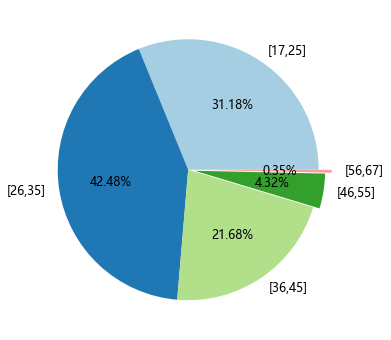

In [107]:
# 画各年龄段用户人数饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0,0,0.05,0.1])
plt.show()

**3.sex**

[Text(0, 0, '55670'), Text(0, 0, '34728')]

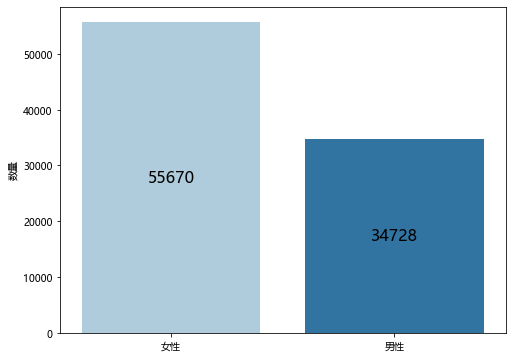

In [108]:
# 计算男女用户人数
female_num = user_info['sex'].value_counts()[0]
male_num = user_info['sex'].value_counts()[1]
# 画男女用户直方图 - 看数量
x = ['女性','男性']
y = [female_num,male_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

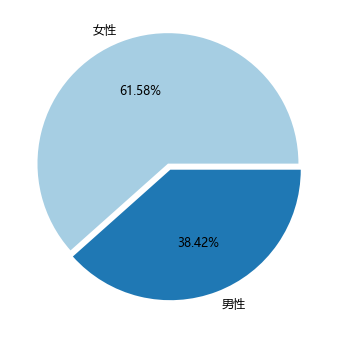

In [109]:
# 画男女用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0.05,0])
plt.show()

**4.country**

[Text(0, 0, '53407'),
 Text(0, 0, '16563'),
 Text(0, 0, '15401'),
 Text(0, 0, '5027')]

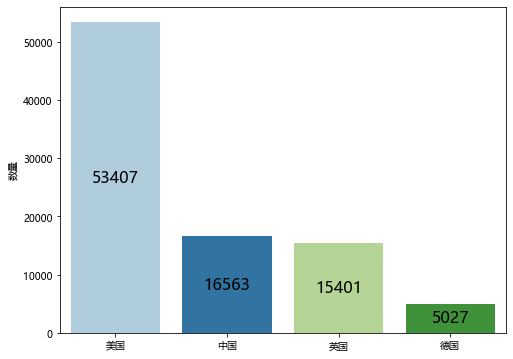

In [110]:
# 计算各国家用户人数 
us_num = user_info['country'].value_counts()[0]
china_num = user_info['country'].value_counts()[1]
uk_num = user_info['country'].value_counts()[2]
germany_num = user_info['country'].value_counts()[3]
# 画各国家用户直方图 - 看数量
x = ['美国','中国','英国','德国']
y = [us_num,china_num,uk_num,germany_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

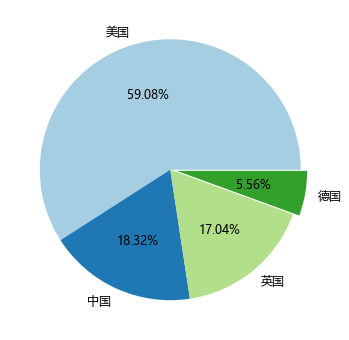

In [111]:
# 画各国家用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0,0,0.05])
plt.show()

**7.source**

[Text(0, 0, '51971'), Text(0, 0, '25054'), Text(0, 0, '13373')]

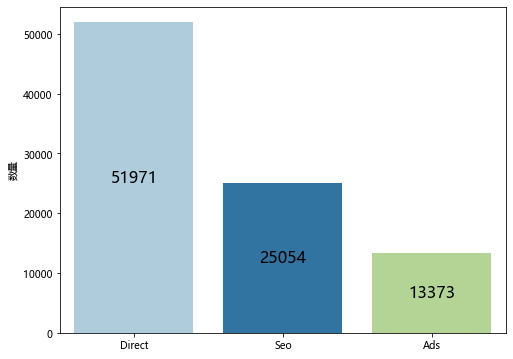

In [113]:
# 计算各用户来源用户人数 
direct_num = user_info['source'].value_counts()[0]
seo_num = user_info['source'].value_counts()[1]
ads_num = user_info['source'].value_counts()[2]
# 画各用户来源用户直方图 - 看数量
x = ['Direct','Seo','Ads']
y = [direct_num,seo_num,ads_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

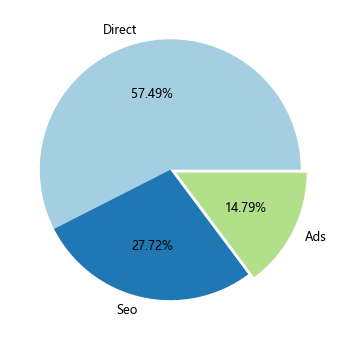

In [114]:
# 画各用户来源用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0,0.05])
plt.show()

**8.total_pages_visited**

<AxesSubplot:xlabel='total_pages_visited', ylabel='Density'>

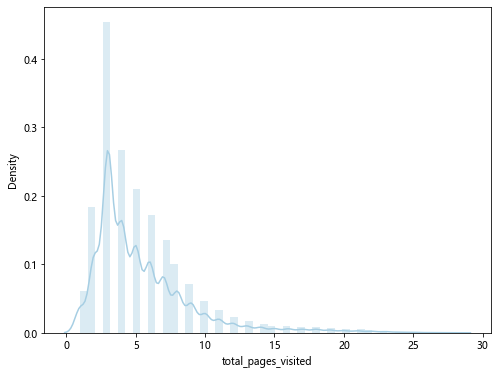

In [115]:
# 画总浏览页面数直方图
plt.figure(figsize=(8,6)) 
sns.distplot(user_info['total_pages_visited'])

In [116]:
#查看页面访问量-从1-28页
print(sorted(user_info_1['total_pages_visited'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


主要分布在1-10页，因此打算分为2组：[1,10],[11,28]

In [117]:
user_info_1.loc[(user_info_1.total_pages_visited>=1)&(user_info_1.total_pages_visited<=10),'tpv_group'] = '[1,10]'
user_info_1.loc[(user_info_1.total_pages_visited>=11)&(user_info_1.total_pages_visited<=28),'tpv_group'] = '[11,28]'

In [118]:
#查看各pv分组
print(sorted(user_info_1['tpv_group'].unique()))

['[1,10]', '[11,28]']


In [119]:
user_info_1['tpv_group'].value_counts()

[1,10]     83045
[11,28]     7353
Name: tpv_group, dtype: int64

[Text(0, 0, '83045'), Text(0, 0, '7353')]

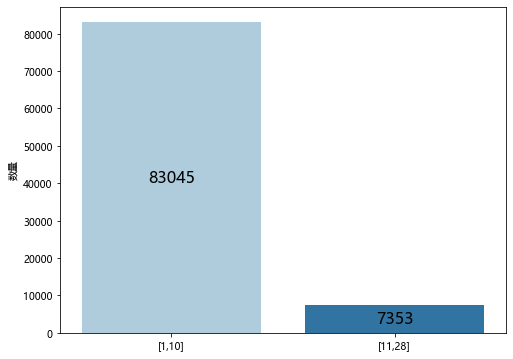

In [120]:
# 计算各浏览页面数分段用户人数
tpv_0110_num = user_info_1['tpv_group'].value_counts()[0]
tpv_1128_num = user_info_1['tpv_group'].value_counts()[1]
# 画各浏览页面数分段用户人数直方图 - 看数量
x = ['[1,10]','[11,28]']
y = [tpv_0110_num,tpv_1128_num]
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.set_palette('Paired')
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

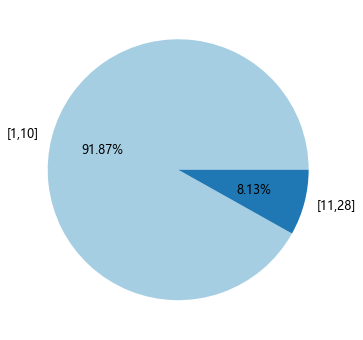

In [121]:
# 画各浏览页面数分段用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0])
plt.show()

### 2.7 数据集合并

merge合并

In [122]:
user_info = pd.merge(user_info,user_home,on = 'user_id', how = 'left')
user_info.rename(columns = {'page': 'home_page'},inplace = True)

In [123]:
user_info = pd.merge(user_info,user_listing,on = 'user_id', how = 'left')
user_info.rename(columns = {'page': 'listing_page'},inplace = True)

In [124]:
user_info = pd.merge(user_info,user_product,on = 'user_id', how = 'left')
user_info.rename(columns = {'page': 'product_page'},inplace = True)

In [125]:
user_info = pd.merge(user_info,user_payment,on = 'user_id', how = 'left')
user_info.rename(columns = {'page': 'payment_page'},inplace = True)

In [126]:
user_info = pd.merge(user_info,user_confirmation,on = 'user_id', how = 'left')
user_info.rename(columns = {'page': 'confirmation_page'},inplace = True)

In [127]:
user_info.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,Direct,3,home_page,listing_page,product_page,NaN,NaN
1,730619,0,27,Male,UK,Direct,5,home_page,NaN,NaN,NaN,NaN
2,261033,0,24,Female,US,Seo,4,home_page,listing_page,NaN,NaN,NaN
3,533685,0,21,Male,UK,Direct,5,home_page,listing_page,product_page,payment_page,NaN
4,699480,0,17,Male,UK,Direct,6,home_page,listing_page,NaN,NaN,NaN


In [128]:
user_info.fillna(0,inplace = True)

In [129]:
user_info.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,Direct,3,home_page,listing_page,product_page,0,0
1,730619,0,27,Male,UK,Direct,5,home_page,0,0,0,0
2,261033,0,24,Female,US,Seo,4,home_page,listing_page,0,0,0
3,533685,0,21,Male,UK,Direct,5,home_page,listing_page,product_page,payment_page,0
4,699480,0,17,Male,UK,Direct,6,home_page,listing_page,0,0,0


In [130]:
# 正则表达式
import re
for col in ['home_page','listing_page','product_page','payment_page','confirmation_page']:
    user_info[col].replace(re.compile('page'),1,inplace = True)

In [131]:
user_info.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,Direct,3,1,1,1,0,0
1,730619,0,27,Male,UK,Direct,5,1,0,0,0,0
2,261033,0,24,Female,US,Seo,4,1,1,0,0,0
3,533685,0,21,Male,UK,Direct,5,1,1,1,1,0
4,699480,0,17,Male,UK,Direct,6,1,1,0,0,0


### 2.8 探索下单转化率和各个特征间的关系

#### 2.8.1 总体下单转化率

In [132]:
# 如果confirmation_page = 1，说明用户下单成功
user_info['confirmation_page'].value_counts()

0    88404
1     1994
Name: confirmation_page, dtype: int64

[Text(0, 0, '88404'), Text(0, 0, '1994')]

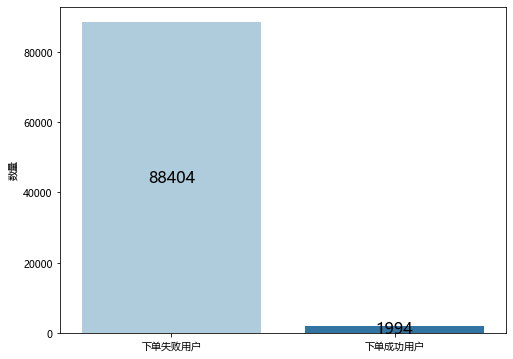

In [133]:
# 计算【下单成功与否】用户人数
com_t_num = user_info['confirmation_page'].value_counts()[1]
com_f_num = user_info['confirmation_page'].value_counts()[0]
# 画【下单成功与否】用户直方图 - 看数量
x = ['下单失败用户','下单成功用户']
y = [com_f_num,com_t_num]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

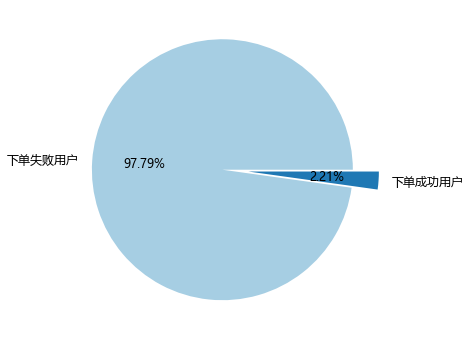

In [134]:
# 画【下单成功与否】用户饼图 - 看占比
plt.figure(figsize=(6,6)) 
plt.pie(y, labels = x,colors = colors, autopct = '%.2f%%',textprops={'fontsize': 12},explode = [0,0.2])
plt.show()

#### 2.8.2 新老用户-下单转化率

In [135]:
user_info.groupby(['new_user'])['confirmation_page'].mean()

new_user
0    0.026583
1    0.011909
Name: confirmation_page, dtype: float64

[Text(0, 0, '0.0265831'), Text(0, 0, '0.0119095')]

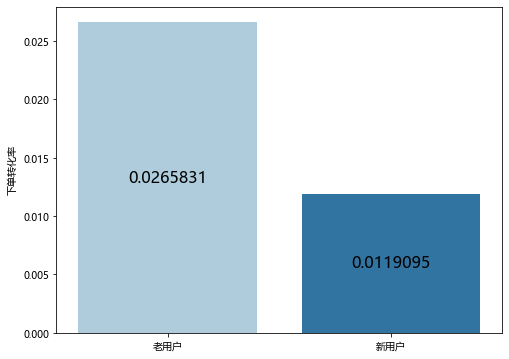

In [136]:
# 计算【新老】用户下单转化率
old_cr = user_info.groupby(['new_user'])['confirmation_page'].mean()[0]
new_cr = user_info.groupby(['new_user'])['confirmation_page'].mean()[1]
# 画【新老】用户下单转化率直方图 
x = ['老用户','新用户']
y = [old_cr,new_cr]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('下单转化率')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

#### 2.8.3 性别-下单转化率

In [137]:
user_info.groupby(['sex'])['confirmation_page'].mean()

sex
Female    0.028705
Male      0.011403
Name: confirmation_page, dtype: float64

[Text(0, 0, '0.0287049'), Text(0, 0, '0.0114029')]

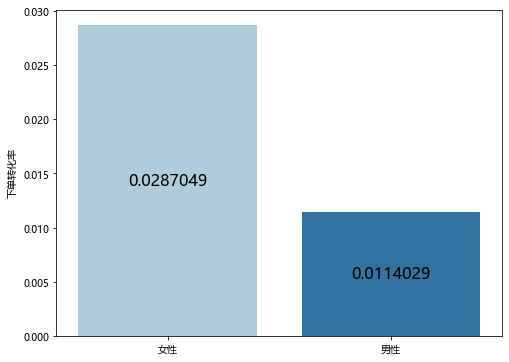

In [138]:
# 计算各【性别】用户下单转化率
female_cr = user_info.groupby(['sex'])['confirmation_page'].mean()[0]
male_cr = user_info.groupby(['sex'])['confirmation_page'].mean()[1]
# 画各【性别】用户下单转化率直方图 
x = ['女性','男性']
y = [female_cr,male_cr]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('下单转化率')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

#### 2.8.4 国家-下单转化率

In [139]:
user_info.groupby(['country'])['confirmation_page'].mean()

country
China      0.014732
Germany    0.030038
UK         0.024674
US         0.022825
Name: confirmation_page, dtype: float64

[Text(0, 0, '0.0147316'),
 Text(0, 0, '0.0300378'),
 Text(0, 0, '0.0246737'),
 Text(0, 0, '0.0228247')]

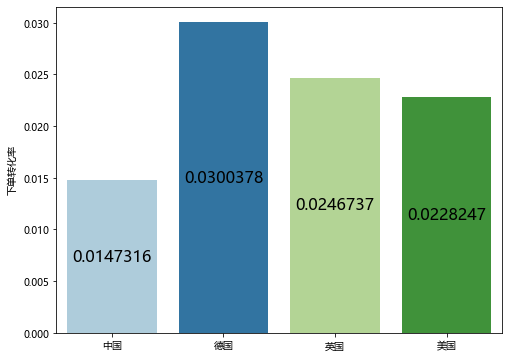

In [140]:
# 计算各【国家】用户下单转化率
china_cr = user_info.groupby(['country'])['confirmation_page'].mean()[0]
germany_cr = user_info.groupby(['country'])['confirmation_page'].mean()[1]
uk_cr = user_info.groupby(['country'])['confirmation_page'].mean()[2]
us_cr = user_info.groupby(['country'])['confirmation_page'].mean()[3]
# 画各【国家】用户下单转化率直方图 
x = ['中国','德国','英国','美国']
y = [china_cr ,germany_cr,uk_cr,us_cr]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('下单转化率')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

#### 2.8.5 用户来源-下单转化率

In [141]:
user_info.groupby(['source'])['confirmation_page'].mean()

source
Ads       0.014806
Direct    0.028881
Seo       0.011775
Name: confirmation_page, dtype: float64

[Text(0, 0, '0.0288815'), Text(0, 0, '0.0117746'), Text(0, 0, '0.014806')]

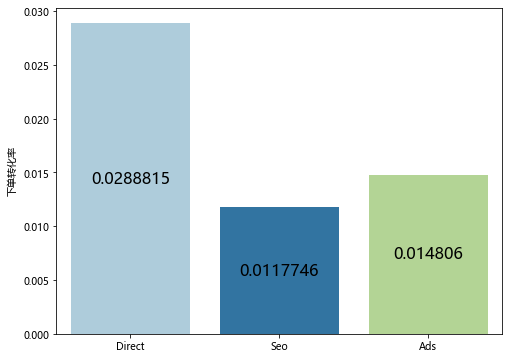

In [142]:
# 计算各【用户来源】用户下单转化率
direct_cr = user_info.groupby(['source'])['confirmation_page'].mean()[1]
seo_cr = user_info.groupby(['source'])['confirmation_page'].mean()[2]
ads_cr = user_info.groupby(['source'])['confirmation_page'].mean()[0]
# 画各【用户来源】用户下单转化率直方图 
x = ['Direct','Seo','Ads']
y = [direct_cr ,seo_cr,ads_cr]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('下单转化率')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

#### 2.8.8 总浏览页面数-下单转化率

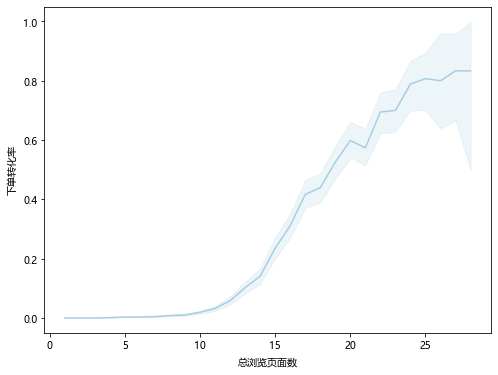

In [143]:
plt.figure(figsize = (8, 6))
sns.lineplot(x = 'total_pages_visited', y = 'confirmation_page', data = user_info)
plt.xlabel('总浏览页面数')
plt.ylabel('下单转化率')
plt.show()

#### 2.8.9 年龄-下单转化率

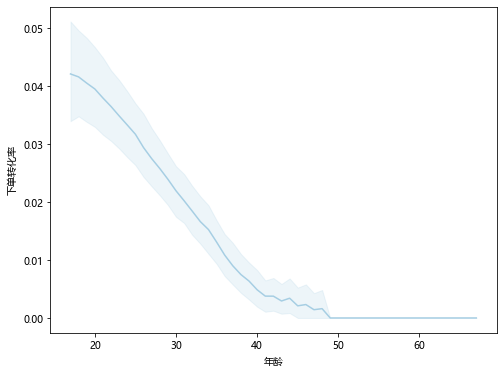

In [144]:
plt.figure(figsize = (8, 6))
sns.lineplot(x = 'age', y = 'confirmation_page', data = user_info)
plt.xlabel('年龄')
plt.ylabel('下单转化率')
plt.show()

#### 2.8.10 新老用户各来源渠道 -下单转化率

In [145]:
user_info.groupby(['new_user','source'])['confirmation_page'].mean()

new_user  source
0         Ads       0.016074
          Direct    0.029814
          Seo       0.012984
1         Ads       0.014180
          Direct    0.008400
          Seo       0.011165
Name: confirmation_page, dtype: float64

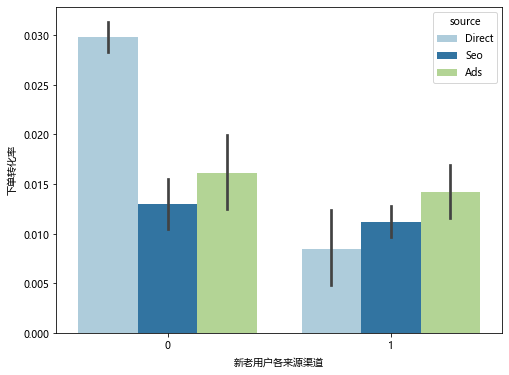

In [146]:
plt.figure(figsize = (8, 6))
sns.barplot(x='new_user',y='confirmation_page',hue='source',data = user_info)
plt.xlabel('新老用户各来源渠道')
plt.ylabel('下单转化率')
plt.show()

老用户直接进入平台的下单转化率更高，新用户通过广告进入平台的下单转化率更高

#### 2.8.11 新老用户各年龄段-下单转化率

In [147]:
user_info_1 = pd.merge(user_info_1,user_home,on = 'user_id', how = 'left')
user_info_1.rename(columns = {'page': 'home_page'},inplace = True)

In [148]:
user_info_1 = pd.merge(user_info_1,user_listing,on = 'user_id', how = 'left')
user_info_1.rename(columns = {'page': 'listing_page'},inplace = True)

In [149]:
user_info_1 = pd.merge(user_info_1,user_product,on = 'user_id', how = 'left')
user_info_1.rename(columns = {'page': 'product_page'},inplace = True)

In [150]:
user_info_1 = pd.merge(user_info_1,user_payment,on = 'user_id', how = 'left')
user_info_1.rename(columns = {'page': 'payment_page'},inplace = True)

In [151]:
user_info_1 = pd.merge(user_info_1,user_confirmation,on = 'user_id', how = 'left')
user_info_1.rename(columns = {'page': 'confirmation_page'},inplace = True)

In [152]:
user_info_1.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,age_group,tpv_group,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,Direct,3,"[17,25]","[1,10]",home_page,listing_page,product_page,NaN,NaN
1,730619,0,27,Male,UK,Direct,5,"[26,35]","[1,10]",home_page,NaN,NaN,NaN,NaN
2,261033,0,24,Female,US,Seo,4,"[17,25]","[1,10]",home_page,listing_page,NaN,NaN,NaN
3,533685,0,21,Male,UK,Direct,5,"[17,25]","[1,10]",home_page,listing_page,product_page,payment_page,NaN
4,699480,0,17,Male,UK,Direct,6,"[17,25]","[1,10]",home_page,listing_page,NaN,NaN,NaN


In [153]:
user_info_1.fillna(0,inplace = True)

In [154]:
user_info_1.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,age_group,tpv_group,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,Direct,3,"[17,25]","[1,10]",home_page,listing_page,product_page,0,0
1,730619,0,27,Male,UK,Direct,5,"[26,35]","[1,10]",home_page,0,0,0,0
2,261033,0,24,Female,US,Seo,4,"[17,25]","[1,10]",home_page,listing_page,0,0,0
3,533685,0,21,Male,UK,Direct,5,"[17,25]","[1,10]",home_page,listing_page,product_page,payment_page,0
4,699480,0,17,Male,UK,Direct,6,"[17,25]","[1,10]",home_page,listing_page,0,0,0


In [156]:
user_info_1.to_csv ('user_info_1_1.csv', index = False, header=True)

In [157]:
# 正则表达式
import re
for col in ['home_page','listing_page','product_page','payment_page','confirmation_page']:
    user_info_1[col].replace(re.compile('page'),1,inplace = True)

In [158]:
user_info_1.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,age_group,tpv_group,home_page,listing_page,product_page,payment_page,confirmation_page
0,654951,0,17,Female,US,Direct,3,"[17,25]","[1,10]",1,1,1,0,0
1,730619,0,27,Male,UK,Direct,5,"[26,35]","[1,10]",1,0,0,0,0
2,261033,0,24,Female,US,Seo,4,"[17,25]","[1,10]",1,1,0,0,0
3,533685,0,21,Male,UK,Direct,5,"[17,25]","[1,10]",1,1,1,1,0
4,699480,0,17,Male,UK,Direct,6,"[17,25]","[1,10]",1,1,0,0,0


In [159]:
user_info_1.groupby(['new_user','age_group'])['confirmation_page'].mean()

new_user  age_group
0         [17,25]      0.043647
          [26,35]      0.026310
          [36,45]      0.007807
          [46,55]      0.001124
          [56,67]      0.000000
1         [17,25]      0.021530
          [26,35]      0.010714
          [36,45]      0.003090
          [46,55]      0.000812
          [56,67]      0.000000
Name: confirmation_page, dtype: float64

### 2.9 漏斗分析

如果是下单转化率下降导致GMV下降，用漏斗分析法，用户从进入平台到最终完成购买这个动作这一整个流程中经历了哪些环节（页面），在不同页面都会存在一定程度的用户流失，如果在某个页面用户流失率非常高，就需要定位到这个页面去看，是不是这个页面或者功能让用户产生了不好的体验，从而导致用户大量流失！

In [160]:
convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for col in range(len(page)-1):
    convertion.append(user_info[page[col+1]].sum()/user_info[page[col]].sum())
convertion

[0.7344299652647183,
 0.6808151707309725,
 0.1334070796460177,
 0.3306799336650083]

In [161]:
list = ['主页->列表页转化率','列表页->产品页转化率','产品页->支付页转化率','支付页->支付完成页转化率']

In [162]:
[*zip(list,convertion)]

[('主页->列表页转化率', 0.7344299652647183),
 ('列表页->产品页转化率', 0.6808151707309725),
 ('产品页->支付页转化率', 0.1334070796460177),
 ('支付页->支付完成页转化率', 0.3306799336650083)]

In [163]:
funnel = pd.DataFrame([*zip(list,convertion)]).rename(columns = {0:'flow',1:'convertion'})

In [164]:
funnel

,flow,convertion
0,主页->列表页转化率,0.734430
1,列表页->产品页转化率,0.680815
2,产品页->支付页转化率,0.133407
3,支付页->支付完成页转化率,0.330680


[Text(0, 0, '0.73443'),
 Text(0, 0, '0.680815'),
 Text(0, 0, '0.133407'),
 Text(0, 0, '0.33068')]

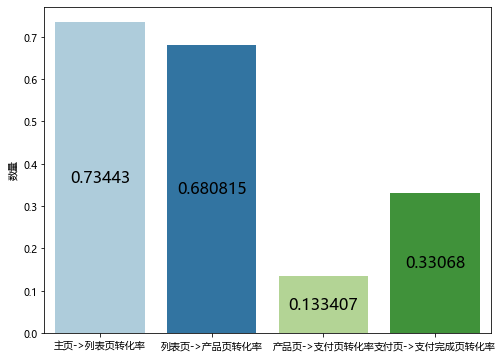

In [165]:
# 漏斗各环节转化率
home_listing_cr = funnel['convertion'][0]
listing_product_cr = funnel['convertion'][1]
product_payment_cr = funnel['convertion'][2]
payment_confirmation_cr = funnel['convertion'][3]
# 画各漏斗各环节转化率直方图 
x = ['主页->列表页转化率','列表页->产品页转化率','产品页->支付页转化率','支付页->支付完成页转化率']
y = [home_listing_cr,listing_product_cr,product_payment_cr,payment_confirmation_cr]
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x, y, ax=ax)
plt.ylabel('数量')
ax.bar_label(ax.containers[0], label_type='center',fontsize=16)

市场上竞争对手的产品，在产品页->支付页转化率在15%-18%，对比我们的产品，产品页->支付页转化率为13.3%，有待提升。那怎么提升？

- 维度拆解分析 和对比分析   
普通的漏斗分析很简单，但一定要通过不同维度的分析，计算对应的转化率，才能挖到真正的业务痛点。
通过对比分析找到核心的维度痛点，并采取相应措施。

#### 2.9.1 漏斗分析：性别维度

In [166]:
sex_funnel = user_info.groupby(['sex'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
sex_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
sex,,,,,
Female,55670,41086,28179,4148,1598
Male,34728,25305,17021,1882,396


In [167]:
sex_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(sex_funnel.index)):
    for col in range(len(page)-1):
        sex_convertion.append(sex_funnel[page[col+1]][i].sum()/sex_funnel[page[col]][i].sum())
sex_convertion

[0.7380276630141908,
 0.6858540622109721,
 0.14720181695588913,
 0.38524590163934425,
 0.7286627505183138,
 0.6726338668247382,
 0.1105692967510722,
 0.2104144527098831]

In [168]:
s = ['Female']*4 + ['Male']*4

In [169]:
[*zip(s,list*2,sex_convertion)]

[('Female', '主页->列表页转化率', 0.7380276630141908),
 ('Female', '列表页->产品页转化率', 0.6858540622109721),
 ('Female', '产品页->支付页转化率', 0.14720181695588913),
 ('Female', '支付页->支付完成页转化率', 0.38524590163934425),
 ('Male', '主页->列表页转化率', 0.7286627505183138),
 ('Male', '列表页->产品页转化率', 0.6726338668247382),
 ('Male', '产品页->支付页转化率', 0.1105692967510722),
 ('Male', '支付页->支付完成页转化率', 0.2104144527098831)]

In [170]:
sex_funnel = pd.DataFrame([*zip(s,list*2,sex_convertion)]).rename(columns={0:'sex',1:'flow',2:'sex_convertion'})
sex_funnel

,sex,flow,sex_convertion
0,Female,主页->列表页转化率,0.738028
1,Female,列表页->产品页转化率,0.685854
2,Female,产品页->支付页转化率,0.147202
3,Female,支付页->支付完成页转化率,0.385246
4,Male,主页->列表页转化率,0.728663
5,Male,列表页->产品页转化率,0.672634
6,Male,产品页->支付页转化率,0.110569
7,Male,支付页->支付完成页转化率,0.210414


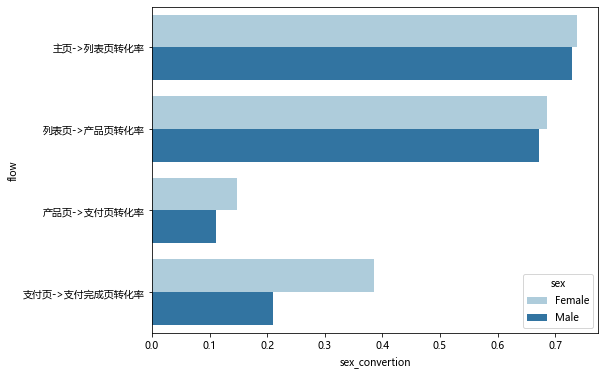

In [171]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'sex_convertion', y='flow',hue='sex',data = sex_funnel)
plt.show()

#### 2.9.3 漏斗分析：国家维度

In [172]:
country_funnel = user_info.groupby(['country'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
country_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
country,,,,,
China,16563,10665,7055,889,244
Germany,5027,4008,2900,425,151
UK,15401,11707,8008,1070,380
US,53407,40011,27237,3646,1219


In [173]:
country_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(country_funnel.index)):
    for col in range(len(page)-1):
        country_convertion.append(country_funnel[page[col+1]][i].sum()/country_funnel[page[col]][i].sum())
country_convertion

[0.6439050896576707,
 0.6615096108766995,
 0.1260099220411056,
 0.2744656917885264,
 0.7972946091108016,
 0.7235528942115769,
 0.14655172413793102,
 0.3552941176470588,
 0.7601454451009675,
 0.6840351926198002,
 0.13361638361638362,
 0.35514018691588783,
 0.7491714569251222,
 0.680737797105796,
 0.13386202592062268,
 0.33433900164563907]

In [174]:
c = ['China']*4 + ['Germany']*4 + ['UK']*4 + ['US']*4

In [175]:
[*zip(c,list*4,country_convertion)]

[('China', '主页->列表页转化率', 0.6439050896576707),
 ('China', '列表页->产品页转化率', 0.6615096108766995),
 ('China', '产品页->支付页转化率', 0.1260099220411056),
 ('China', '支付页->支付完成页转化率', 0.2744656917885264),
 ('Germany', '主页->列表页转化率', 0.7972946091108016),
 ('Germany', '列表页->产品页转化率', 0.7235528942115769),
 ('Germany', '产品页->支付页转化率', 0.14655172413793102),
 ('Germany', '支付页->支付完成页转化率', 0.3552941176470588),
 ('UK', '主页->列表页转化率', 0.7601454451009675),
 ('UK', '列表页->产品页转化率', 0.6840351926198002),
 ('UK', '产品页->支付页转化率', 0.13361638361638362),
 ('UK', '支付页->支付完成页转化率', 0.35514018691588783),
 ('US', '主页->列表页转化率', 0.7491714569251222),
 ('US', '列表页->产品页转化率', 0.680737797105796),
 ('US', '产品页->支付页转化率', 0.13386202592062268),
 ('US', '支付页->支付完成页转化率', 0.33433900164563907)]

In [176]:
country_funnel = pd.DataFrame([*zip(c,list*4,country_convertion)]).rename(columns={0:'country',1:'flow',2:'country_convertion'})
country_funnel

,country,flow,country_convertion
0,China,主页->列表页转化率,0.643905
1,China,列表页->产品页转化率,0.661510
2,China,产品页->支付页转化率,0.126010
3,China,支付页->支付完成页转化率,0.274466
4,Germany,主页->列表页转化率,0.797295
5,Germany,列表页->产品页转化率,0.723553
6,Germany,产品页->支付页转化率,0.146552
7,Germany,支付页->支付完成页转化率,0.355294
8,UK,主页->列表页转化率,0.760145
9,UK,列表页->产品页转化率,0.684035


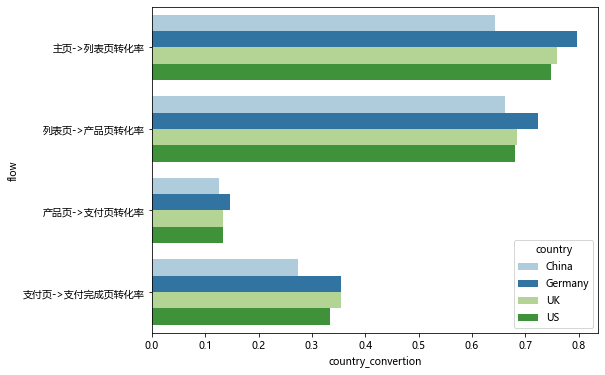

In [177]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'country_convertion', y='flow',hue='country',data = country_funnel)
plt.show()

#### 2.9.4 漏斗分析：用户新老维度

In [178]:
new_user_funnel = user_info.groupby(['new_user'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
new_user_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
new_user,,,,,
0,62521,46005,31521,4499,1662
1,27877,20386,13679,1531,332


In [179]:
new_user_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(new_user_funnel.index)):
    for col in range(len(page)-1):
        new_user_convertion.append(new_user_funnel[page[col+1]][i].sum()/new_user_funnel[page[col]][i].sum())
new_user_convertion

[0.7358327601925753,
 0.6851646560156505,
 0.1427302433298436,
 0.36941542565014446,
 0.7312838540732504,
 0.6709997056803689,
 0.11192338621244242,
 0.21685173089483997]

In [180]:
n = ['0']*4 + ['1']*4

In [181]:
[*zip(n,list*2,new_user_convertion)]

[('0', '主页->列表页转化率', 0.7358327601925753),
 ('0', '列表页->产品页转化率', 0.6851646560156505),
 ('0', '产品页->支付页转化率', 0.1427302433298436),
 ('0', '支付页->支付完成页转化率', 0.36941542565014446),
 ('1', '主页->列表页转化率', 0.7312838540732504),
 ('1', '列表页->产品页转化率', 0.6709997056803689),
 ('1', '产品页->支付页转化率', 0.11192338621244242),
 ('1', '支付页->支付完成页转化率', 0.21685173089483997)]

In [182]:
new_user_funnel = pd.DataFrame([*zip(n,list*4,new_user_convertion)]).rename(columns={0:'new_user',1:'flow',2:'new_user_convertion'})
new_user_funnel

,new_user,flow,new_user_convertion
0,0,主页->列表页转化率,0.735833
1,0,列表页->产品页转化率,0.685165
2,0,产品页->支付页转化率,0.142730
3,0,支付页->支付完成页转化率,0.369415
4,1,主页->列表页转化率,0.731284
5,1,列表页->产品页转化率,0.671000
6,1,产品页->支付页转化率,0.111923
7,1,支付页->支付完成页转化率,0.216852


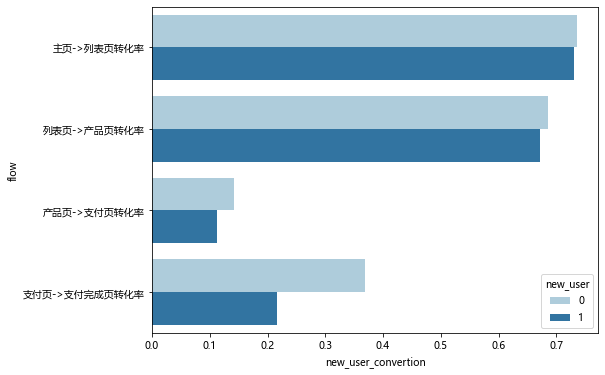

In [183]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'new_user_convertion', y='flow',hue='new_user',data = new_user_funnel)
plt.show()

#### 漏斗分析：用户新老+来源渠道

In [185]:
new_user = user_info[user_info['new_user']==1]

In [186]:
new_user_source_funnel = new_user.groupby(['source'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
new_user_source_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
source,,,,,
Ads,8956,6544,4389,534,127
Direct,2262,1671,1114,105,19
Seo,16659,12171,8176,892,186


In [187]:
new_user_source_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(new_user_source_funnel.index)):
    for col in range(len(page)-1):
        new_user_source_convertion.append(new_user_source_funnel[page[col+1]][i].sum()/new_user_source_funnel[page[col]][i].sum())
new_user_source_convertion

[0.7306833407771326,
 0.6706907090464548,
 0.12166780587833219,
 0.23782771535580524,
 0.7387267904509284,
 0.6666666666666666,
 0.09425493716337523,
 0.18095238095238095,
 0.7305960741941293,
 0.6717607427491579,
 0.10909980430528375,
 0.2085201793721973]

In [188]:
n = ['Ads']*4 + ['Direct']*4 + ['Seo']*4

In [189]:
new_user_source_funnel = pd.DataFrame([*zip(n,list*3,new_user_source_convertion)]).rename(columns={0:'source',1:'flow',2:'new_user_source_convertion'})
new_user_source_funnel

,source,flow,new_user_source_convertion
0,Ads,主页->列表页转化率,0.730683
1,Ads,列表页->产品页转化率,0.670691
2,Ads,产品页->支付页转化率,0.121668
3,Ads,支付页->支付完成页转化率,0.237828
4,Direct,主页->列表页转化率,0.738727
5,Direct,列表页->产品页转化率,0.666667
6,Direct,产品页->支付页转化率,0.094255
7,Direct,支付页->支付完成页转化率,0.180952
8,Seo,主页->列表页转化率,0.730596
9,Seo,列表页->产品页转化率,0.671761


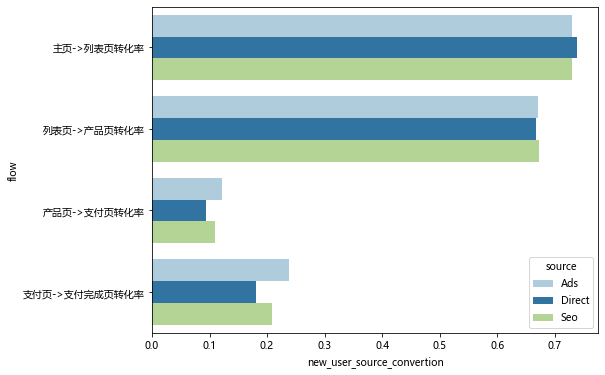

In [191]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'new_user_source_convertion', y='flow',hue='source',data = new_user_source_funnel)
plt.show()

In [192]:
new_user = user_info[user_info['new_user']==0]

In [193]:
new_user_source_funnel = new_user.groupby(['source'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
new_user_source_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
source,,,,,
Ads,4417,3271,2222,260,71
Direct,49709,36678,25207,3713,1482
Seo,8395,6056,4092,526,109


In [194]:
new_user_source_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(new_user_source_funnel.index)):
    for col in range(len(page)-1):
        new_user_source_convertion.append(new_user_source_funnel[page[col+1]][i].sum()/new_user_source_funnel[page[col]][i].sum())
new_user_source_convertion

[0.7405478831786281,
 0.6793029654539896,
 0.11701170117011701,
 0.27307692307692305,
 0.7378543120964011,
 0.6872512132613556,
 0.14730035307652636,
 0.39913816321034207,
 0.7213817748659916,
 0.6756935270805813,
 0.12854349951124144,
 0.20722433460076045]

In [195]:
n = ['Ads']*4 + ['Direct']*4 + ['Seo']*4

In [196]:
new_user_source_funnel = pd.DataFrame([*zip(n,list*3,new_user_source_convertion)]).rename(columns={0:'source',1:'flow',2:'new_user_source_convertion'})
new_user_source_funnel

,source,flow,new_user_source_convertion
0,Ads,主页->列表页转化率,0.740548
1,Ads,列表页->产品页转化率,0.679303
2,Ads,产品页->支付页转化率,0.117012
3,Ads,支付页->支付完成页转化率,0.273077
4,Direct,主页->列表页转化率,0.737854
5,Direct,列表页->产品页转化率,0.687251
6,Direct,产品页->支付页转化率,0.147300
7,Direct,支付页->支付完成页转化率,0.399138
8,Seo,主页->列表页转化率,0.721382
9,Seo,列表页->产品页转化率,0.675694


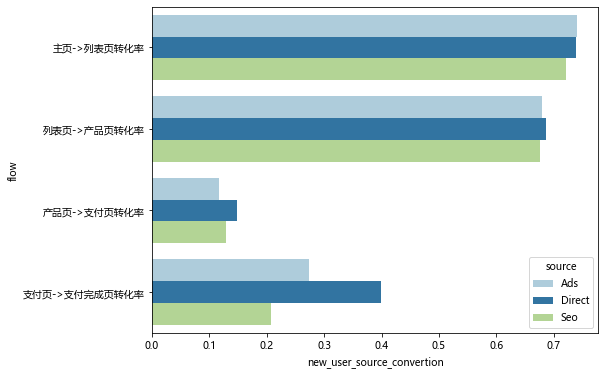

In [197]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'new_user_source_convertion', y='flow',hue='source',data = new_user_source_funnel)
plt.show()

#### 2.9.6 漏斗分析：用户来源维度

In [198]:
source_funnel = user_info.groupby(['source'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
source_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
source,,,,,
Ads,13373,9815,6611,794,198
Direct,51971,38349,26321,3818,1501
Seo,25054,18227,12268,1418,295


In [199]:
source_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(source_funnel.index)):
    for col in range(len(page)-1):
        source_convertion.append(source_funnel[page[col+1]][i].sum()/source_funnel[page[col]][i].sum())
source_convertion

[0.7339415239662006,
 0.6735608762098828,
 0.12010285887157768,
 0.24937027707808565,
 0.737892286082623,
 0.6863542726016324,
 0.14505527905474716,
 0.393137768465165,
 0.7275085814640376,
 0.6730674274428047,
 0.1155852624714705,
 0.20803949224259521]

In [200]:
s = ['Ads']*4 + ['Direct']*4 + ['Seo']*4 

In [201]:
[*zip(s,list*3,source_convertion)]

[('Ads', '主页->列表页转化率', 0.7339415239662006),
 ('Ads', '列表页->产品页转化率', 0.6735608762098828),
 ('Ads', '产品页->支付页转化率', 0.12010285887157768),
 ('Ads', '支付页->支付完成页转化率', 0.24937027707808565),
 ('Direct', '主页->列表页转化率', 0.737892286082623),
 ('Direct', '列表页->产品页转化率', 0.6863542726016324),
 ('Direct', '产品页->支付页转化率', 0.14505527905474716),
 ('Direct', '支付页->支付完成页转化率', 0.393137768465165),
 ('Seo', '主页->列表页转化率', 0.7275085814640376),
 ('Seo', '列表页->产品页转化率', 0.6730674274428047),
 ('Seo', '产品页->支付页转化率', 0.1155852624714705),
 ('Seo', '支付页->支付完成页转化率', 0.20803949224259521)]

In [202]:
source_funnel = pd.DataFrame([*zip(s,list*3,source_convertion)]).rename(columns={0:'source',1:'flow',2:'source_convertion'})
source_funnel

,source,flow,source_convertion
0,Ads,主页->列表页转化率,0.733942
1,Ads,列表页->产品页转化率,0.673561
2,Ads,产品页->支付页转化率,0.120103
3,Ads,支付页->支付完成页转化率,0.249370
4,Direct,主页->列表页转化率,0.737892
5,Direct,列表页->产品页转化率,0.686354
6,Direct,产品页->支付页转化率,0.145055
7,Direct,支付页->支付完成页转化率,0.393138
8,Seo,主页->列表页转化率,0.727509
9,Seo,列表页->产品页转化率,0.673067


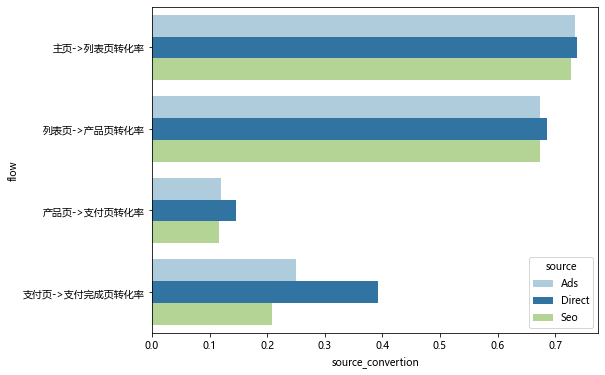

In [203]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'source_convertion', y='flow',hue='source',data = source_funnel)
plt.show()

#### 2.9.7 漏斗分析：年龄维度

因为年龄是连续变量，不好统计，因此将年龄分段统计

In [204]:
#为了不改变原来的数据，深拷贝一个user_info_1
user_info_1 = user_info.copy(deep=True)

In [205]:
#查看年龄-从17岁67岁
print(sorted(user_info_1['age'].unique()))

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


打算分为5个年龄阶段：[17,25],[26-35],[36,45],[46,55],[56-67]

In [206]:
user_info_1.loc[(user_info_1.age>=16)&(user_info_1.age<=25),'age_group'] = '[16,25]'
user_info_1.loc[(user_info_1.age>=26)&(user_info_1.age<=35),'age_group'] = '[26,35]'
user_info_1.loc[(user_info_1.age>=36)&(user_info_1.age<=45),'age_group'] = '[36,45]'
user_info_1.loc[(user_info_1.age>=46)&(user_info_1.age<=55),'age_group'] = '[46,55]'
user_info_1.loc[(user_info_1.age>=56)&(user_info_1.age<=67),'age_group'] = '[56,67]'

In [207]:
#查看各年龄段
print(sorted(user_info_1['age_group'].unique()))

['[16,25]', '[26,35]', '[36,45]', '[46,55]', '[56,67]']


In [208]:
age_group_funnel = user_info_1.groupby(['age_group'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
age_group_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
age_group,,,,,
"[16,25]",28182,20847,14262,2281,1039
"[26,35]",38404,28264,19293,2524,827
"[36,45]",19598,14241,9627,1053,124
"[46,55]",3901,2820,1867,163,4
"[56,67]",313,219,151,9,0


In [209]:
age_group_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(age_group_funnel.index)):
    for col in range(len(page)-1):
        age_group_convertion.append(age_group_funnel[page[col+1]][i].sum()/age_group_funnel[page[col]][i].sum())
age_group_convertion

[0.7397274856291249,
 0.6841272125485681,
 0.1599354929182443,
 0.45550197281893906,
 0.7359650036454536,
 0.6825997735635437,
 0.13082465142797906,
 0.3276545166402536,
 0.7266557812021635,
 0.6760058984621866,
 0.10937986911810534,
 0.1177587844254511,
 0.7228915662650602,
 0.6620567375886525,
 0.08730583824317087,
 0.024539877300613498,
 0.6996805111821086,
 0.6894977168949772,
 0.059602649006622516,
 0.0]

In [210]:
a = ['[16,25]']*4 + ['[26,35]']*4 + ['[36,45]']*4 + ['[46,55]']*4 + ['[56,67]']*4 

In [211]:
[*zip(a,list*5,age_group_convertion)]

[('[16,25]', '主页->列表页转化率', 0.7397274856291249),
 ('[16,25]', '列表页->产品页转化率', 0.6841272125485681),
 ('[16,25]', '产品页->支付页转化率', 0.1599354929182443),
 ('[16,25]', '支付页->支付完成页转化率', 0.45550197281893906),
 ('[26,35]', '主页->列表页转化率', 0.7359650036454536),
 ('[26,35]', '列表页->产品页转化率', 0.6825997735635437),
 ('[26,35]', '产品页->支付页转化率', 0.13082465142797906),
 ('[26,35]', '支付页->支付完成页转化率', 0.3276545166402536),
 ('[36,45]', '主页->列表页转化率', 0.7266557812021635),
 ('[36,45]', '列表页->产品页转化率', 0.6760058984621866),
 ('[36,45]', '产品页->支付页转化率', 0.10937986911810534),
 ('[36,45]', '支付页->支付完成页转化率', 0.1177587844254511),
 ('[46,55]', '主页->列表页转化率', 0.7228915662650602),
 ('[46,55]', '列表页->产品页转化率', 0.6620567375886525),
 ('[46,55]', '产品页->支付页转化率', 0.08730583824317087),
 ('[46,55]', '支付页->支付完成页转化率', 0.024539877300613498),
 ('[56,67]', '主页->列表页转化率', 0.6996805111821086),
 ('[56,67]', '列表页->产品页转化率', 0.6894977168949772),
 ('[56,67]', '产品页->支付页转化率', 0.059602649006622516),
 ('[56,67]', '支付页->支付完成页转化率', 0.0)]

In [212]:
age_group_funnel = pd.DataFrame([*zip(a,list*5,age_group_convertion)]).rename(columns={0:'age_group',1:'flow',2:'age_group_convertion'})
age_group_funnel

,age_group,flow,age_group_convertion
0,"[16,25]",主页->列表页转化率,0.739727
1,"[16,25]",列表页->产品页转化率,0.684127
2,"[16,25]",产品页->支付页转化率,0.159935
3,"[16,25]",支付页->支付完成页转化率,0.455502
4,"[26,35]",主页->列表页转化率,0.735965
5,"[26,35]",列表页->产品页转化率,0.682600
6,"[26,35]",产品页->支付页转化率,0.130825
7,"[26,35]",支付页->支付完成页转化率,0.327655
8,"[36,45]",主页->列表页转化率,0.726656
9,"[36,45]",列表页->产品页转化率,0.676006


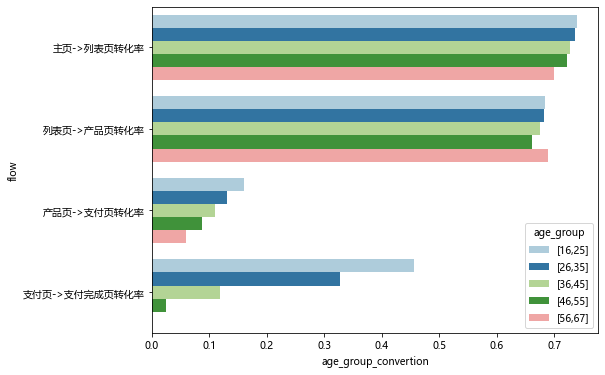

In [213]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'age_group_convertion', y='flow',hue='age_group',data = age_group_funnel)
plt.show()

#### 2.9.7 漏斗分析：年龄+性别

In [297]:
#为了不改变原来的数据，深拷贝一个user_info_1
user_info_1 = user_info.copy(deep=True)

In [298]:
user_info_1.loc[(user_info_1.age>=16)&(user_info_1.age<=25),'age_group'] = '[16,25]'
user_info_1.loc[(user_info_1.age>=26)&(user_info_1.age<=35),'age_group'] = '[26,35]'
user_info_1.loc[(user_info_1.age>=36)&(user_info_1.age<=45),'age_group'] = '[36,45]'
user_info_1.loc[(user_info_1.age>=46)&(user_info_1.age<=55),'age_group'] = '[46,55]'
user_info_1.loc[(user_info_1.age>=56)&(user_info_1.age<=67),'age_group'] = '[56,67]'

In [299]:
f_sex = user_info_1[user_info_1['sex']=='Female']

In [300]:
f_sex

,user_id,new_user,age,sex,country,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page,age_group
0,654951,0,17,Female,US,Direct,3,1,1,1,0,0,"[16,25]"
2,261033,0,24,Female,US,Seo,4,1,1,0,0,0,"[16,25]"
5,354463,1,29,Female,US,Ads,3,1,1,1,0,0,"[26,35]"
6,924836,0,28,Female,UK,Direct,4,1,0,0,0,0,"[26,35]"
7,242953,1,25,Female,US,Direct,4,1,1,1,0,0,"[16,25]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90387,362681,1,17,Female,China,Ads,10,1,0,0,0,0,"[16,25]"
90389,607167,0,17,Female,US,Direct,3,1,1,0,0,0,"[16,25]"
90392,118454,1,17,Female,US,Ads,3,1,0,0,0,0,"[16,25]"
90393,888887,0,17,Female,US,Seo,5,1,1,1,1,0,"[16,25]"


In [301]:
sex_age_funnel = f_sex.groupby(['age_group'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
sex_age_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
age_group,,,,,
"[16,25]",16670,12441,8645,1571,820
"[26,35]",24837,18326,12583,1791,666
"[36,45]",11734,8566,5796,693,108
"[46,55]",2254,1623,1067,88,4
"[56,67]",175,130,88,5,0


In [305]:
sex_age_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(sex_age_funnel.index)):
    for col in range(len(page)-1):
        sex_age_convertion.append(sex_age_funnel[page[col+1]][i].sum()/sex_age_funnel[page[col]][i].sum())
sex_age_convertion

[0.7463107378524295,
 0.6948798328108673,
 0.18172353961827645,
 0.5219605346912795,
 0.7378507871321013,
 0.6866201025864891,
 0.1423348962886434,
 0.37185929648241206,
 0.7300153400374979,
 0.676628531403222,
 0.11956521739130435,
 0.15584415584415584,
 0.7200532386867791,
 0.6574245224892175,
 0.08247422680412371,
 0.045454545454545456,
 0.7428571428571429,
 0.676923076923077,
 0.056818181818181816,
 0.0]

In [306]:
n = ['[16,25]']*4 + ['[26,35]']*4 + ['[36,45]']*4 + ['[46,55]']*4 + ['[56,67]']*4

In [307]:
sex_age_funnel = pd.DataFrame([*zip(n,list*5,sex_age_convertion)]).rename(columns={0:'age_group',1:'flow',2:'sex_age_convertion'})
sex_age_funnel

,age_group,flow,sex_age_convertion
0,"[16,25]",主页->列表页转化率,0.746311
1,"[16,25]",列表页->产品页转化率,0.694880
2,"[16,25]",产品页->支付页转化率,0.181724
3,"[16,25]",支付页->支付完成页转化率,0.521961
4,"[26,35]",主页->列表页转化率,0.737851
5,"[26,35]",列表页->产品页转化率,0.686620
6,"[26,35]",产品页->支付页转化率,0.142335
7,"[26,35]",支付页->支付完成页转化率,0.371859
8,"[36,45]",主页->列表页转化率,0.730015
9,"[36,45]",列表页->产品页转化率,0.676629


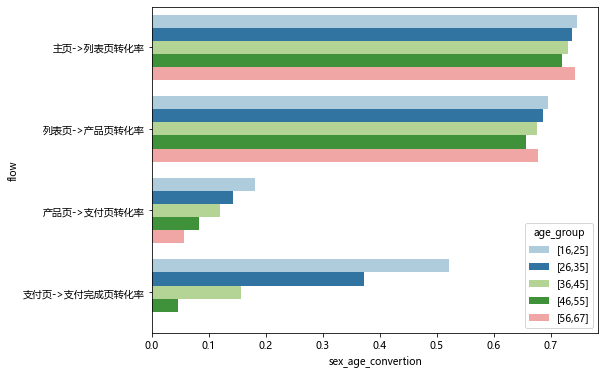

In [309]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'sex_age_convertion', y='flow',hue='age_group',data = sex_age_funnel)
plt.show()

In [192]:
new_user = user_info[user_info['new_user']==0]

In [193]:
new_user_source_funnel = new_user.groupby(['source'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
new_user_source_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
source,,,,,
Ads,4417,3271,2222,260,71
Direct,49709,36678,25207,3713,1482
Seo,8395,6056,4092,526,109


In [194]:
new_user_source_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(new_user_source_funnel.index)):
    for col in range(len(page)-1):
        new_user_source_convertion.append(new_user_source_funnel[page[col+1]][i].sum()/new_user_source_funnel[page[col]][i].sum())
new_user_source_convertion

[0.7405478831786281,
 0.6793029654539896,
 0.11701170117011701,
 0.27307692307692305,
 0.7378543120964011,
 0.6872512132613556,
 0.14730035307652636,
 0.39913816321034207,
 0.7213817748659916,
 0.6756935270805813,
 0.12854349951124144,
 0.20722433460076045]

In [195]:
n = ['Ads']*4 + ['Direct']*4 + ['Seo']*4

In [196]:
new_user_source_funnel = pd.DataFrame([*zip(n,list*3,new_user_source_convertion)]).rename(columns={0:'source',1:'flow',2:'new_user_source_convertion'})
new_user_source_funnel

,source,flow,new_user_source_convertion
0,Ads,主页->列表页转化率,0.740548
1,Ads,列表页->产品页转化率,0.679303
2,Ads,产品页->支付页转化率,0.117012
3,Ads,支付页->支付完成页转化率,0.273077
4,Direct,主页->列表页转化率,0.737854
5,Direct,列表页->产品页转化率,0.687251
6,Direct,产品页->支付页转化率,0.147300
7,Direct,支付页->支付完成页转化率,0.399138
8,Seo,主页->列表页转化率,0.721382
9,Seo,列表页->产品页转化率,0.675694


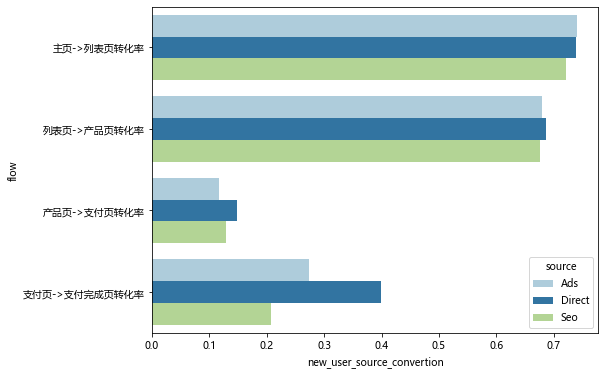

In [197]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'new_user_source_convertion', y='flow',hue='source',data = new_user_source_funnel)
plt.show()

#### 2.9.8 漏斗分析：页面访问量

In [214]:
#查看页面访问量-从1-28页
print(sorted(user_info_1['total_pages_visited'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


打算分为3组：[1,10],[11-20],[21,30]

In [215]:
user_info_1.loc[(user_info_1.total_pages_visited>=1)&(user_info_1.total_pages_visited<=10),'pv'] = '[1,10]'
user_info_1.loc[(user_info_1.total_pages_visited>=11)&(user_info_1.total_pages_visited<=21),'pv'] = '[11,20]'
user_info_1.loc[(user_info_1.total_pages_visited>=21)&(user_info_1.total_pages_visited<=30),'pv'] = '[21,30]'

In [216]:
#查看各pv分组
print(sorted(user_info_1['pv'].unique()))

['[1,10]', '[11,20]', '[21,30]']


In [217]:
pv_funnel = user_info_1.groupby(['pv'])['home_page','listing_page','product_page','payment_page','confirmation_page'].sum()
pv_funnel

,home_page,listing_page,product_page,payment_page,confirmation_page
pv,,,,,
"[1,10]",83045,60562,40627,3779,224
"[11,20]",6594,5129,3930,1720,1249
"[21,30]",759,700,643,531,521


In [218]:
pv_convertion = []
page = ['home_page','listing_page','product_page','payment_page','confirmation_page']
for i in range(len(pv_funnel.index)):
    for col in range(len(page)-1):
        pv_convertion.append(pv_funnel[page[col+1]][i].sum()/pv_funnel[page[col]][i].sum())
pv_convertion

[0.7292672647359865,
 0.6708331957332981,
 0.09301695916508726,
 0.05927494046043927,
 0.7778283287837428,
 0.7662312341587054,
 0.43765903307888043,
 0.7261627906976744,
 0.922266139657444,
 0.9185714285714286,
 0.8258164852255054,
 0.9811676082862524]

In [219]:
p = ['[1,10]']*4 + ['[11,20]']*4 + ['[21,30]']*4

In [220]:
[*zip(p,list*3,pv_convertion)]

[('[1,10]', '主页->列表页转化率', 0.7292672647359865),
 ('[1,10]', '列表页->产品页转化率', 0.6708331957332981),
 ('[1,10]', '产品页->支付页转化率', 0.09301695916508726),
 ('[1,10]', '支付页->支付完成页转化率', 0.05927494046043927),
 ('[11,20]', '主页->列表页转化率', 0.7778283287837428),
 ('[11,20]', '列表页->产品页转化率', 0.7662312341587054),
 ('[11,20]', '产品页->支付页转化率', 0.43765903307888043),
 ('[11,20]', '支付页->支付完成页转化率', 0.7261627906976744),
 ('[21,30]', '主页->列表页转化率', 0.922266139657444),
 ('[21,30]', '列表页->产品页转化率', 0.9185714285714286),
 ('[21,30]', '产品页->支付页转化率', 0.8258164852255054),
 ('[21,30]', '支付页->支付完成页转化率', 0.9811676082862524)]

In [221]:
pv_funnel = pd.DataFrame([*zip(p,list*3,pv_convertion)]).rename(columns={0:'pv',1:'flow',2:'pv_convertion'})
pv_funnel

,pv,flow,pv_convertion
0,"[1,10]",主页->列表页转化率,0.729267
1,"[1,10]",列表页->产品页转化率,0.670833
2,"[1,10]",产品页->支付页转化率,0.093017
3,"[1,10]",支付页->支付完成页转化率,0.059275
4,"[11,20]",主页->列表页转化率,0.777828
5,"[11,20]",列表页->产品页转化率,0.766231
6,"[11,20]",产品页->支付页转化率,0.437659
7,"[11,20]",支付页->支付完成页转化率,0.726163
8,"[21,30]",主页->列表页转化率,0.922266
9,"[21,30]",列表页->产品页转化率,0.918571


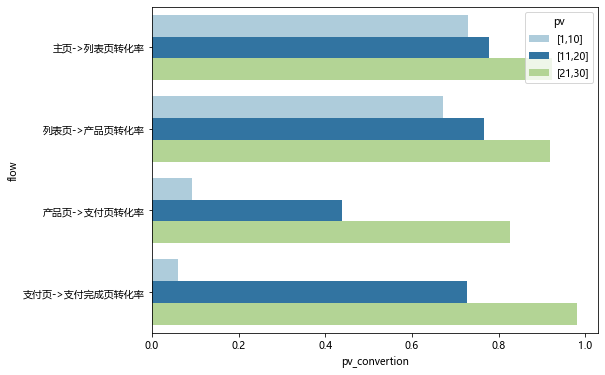

In [222]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'pv_convertion', y='flow',hue='pv',data = pv_funnel)
plt.show()

## 3.特征工程

In [223]:
# 当deep = false相当于引用，原值改变复制的结果随之改变，等价于model_info = user_info
model_info = user_info.copy(deep=True)

In [224]:
# 把转化converted作为我的label(因变量)
model_info['converted'] = model_info['confirmation_page']

In [225]:
model_info.head()

,user_id,new_user,age,sex,country,source,total_pages_visited,home_page,listing_page,product_page,payment_page,confirmation_page,converted
0,654951,0,17,Female,US,Direct,3,1,1,1,0,0,0
1,730619,0,27,Male,UK,Direct,5,1,0,0,0,0,0
2,261033,0,24,Female,US,Seo,4,1,1,0,0,0,0
3,533685,0,21,Male,UK,Direct,5,1,1,1,1,0,0
4,699480,0,17,Male,UK,Direct,6,1,1,0,0,0,0


### 3.2 特征选择

In [226]:
#去除掉user_id,home_page,listing_page,product_page,confirmation_page
model_info.drop(['user_id','home_page','listing_page','product_page','payment_page','confirmation_page'],axis=1,inplace = True)

In [227]:
model_info.head()

,new_user,age,sex,country,source,total_pages_visited,converted
0,0,17,Female,US,Direct,3,0
1,0,27,Male,UK,Direct,5,0
2,0,24,Female,US,Seo,4,0
3,0,21,Male,UK,Direct,5,0
4,0,17,Male,UK,Direct,6,0


### 3.3 特征处理

对于逻辑回归模型：   
- 连续型数据特征：不处理或标准化处理
- 无序类别特征：OneHotEncoder
- 有序类别特征：labelEncoder

In [228]:
data_lR = pd.get_dummies(model_info, drop_first = False)

In [259]:
# 连续特征age，total_pages_visited进行最值归一化处理,逻辑回归使用最值归一化可以使收敛的速度更快
from sklearn.preprocessing import MinMaxScaler
data_lR['age'] = MinMaxScaler().fit_transform(data_lR['age'].values.reshape(-1,1)).reshape(1,-1)[0]
data_lR['total_pages_visited'] = MinMaxScaler().fit_transform(data_lR['total_pages_visited'].values.reshape(-1,1)).reshape(1,-1)[0]

In [232]:
data_lR.head()

,new_user,age,total_pages_visited,converted,sex_Female,sex_Male,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,0,0.00,0.074074,0,1,0,0,0,0,1,0,1,0
1,0,0.20,0.148148,0,0,1,0,0,1,0,0,1,0
2,0,0.14,0.111111,0,1,0,0,0,0,1,0,0,1
3,0,0.08,0.148148,0,0,1,0,0,1,0,0,1,0
4,0,0.00,0.185185,0,0,1,0,0,1,0,0,1,0


对于树模型（决策树和随机森林）：
- 连续型数据特征不处理
- 类别特征OneHotEncoder和labelencoder都可以，数值只是个类别符号，没有大小概念，即没有偏序关系，只有特征处于分布的哪一部分的概念

In [233]:
#OneHotEncoder
data_tree = pd.get_dummies(model_info, drop_first = False)

In [234]:
#labelEncoder
from sklearn.preprocessing import LabelEncoder
data_tree1 = model_info.copy(deep = True)

#性别
sex_le = LabelEncoder()
data_tree1['sex'] = sex_le.fit_transform(data_tree1['sex'])

In [235]:
#撤销转换，看下原来是啥，0，1分别对应什么
sex_le.inverse_transform([0,1])

array(['Female', 'Male'], dtype=object)

In [236]:
#再转回来
sex_le.transform(['Female','Male'])

array([0, 1])

### 3.4 建模

#### 3.4.1 逻辑回归

##### 3.4.1.1 划分训练集和测试集

In [237]:
from sklearn.model_selection import train_test_split
np.random.seed(4684)

x = data_lR.drop(['converted'],axis = 1)
y = data_lR['converted']

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8)
#实际工作场景中，还有可能是按时间来划分训练集和测试集

In [238]:
x_train.shape

(72318, 12)

In [239]:
y_train.shape

(72318,)

##### 3.4.1.2 用训练集训练模型

In [240]:
from sklearn.linear_model import LogisticRegression
logic_model = LogisticRegression(random_state = 42)

#设置显示模型参数
from sklearn import set_config
set_config(print_changed_only = False)

logic_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### 3.4.1.3 用训练好的模型来预测测试集

In [241]:
y_prediction = logic_model.predict(x_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [242]:
#对y_prediction的结果进行评估-准确率、精确率、召回率、f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#这里是为了做混淆矩阵
data = {'y_test': y_test,
        'y_predicted': y_prediction}
df = pd.DataFrame(data, columns = ['y_test','y_predicted'])

#Crosstab 交叉列表取值，第一个参数是列，第二个参数是行
confusion_matrix = pd.crosstab(df['y_test'],df['y_predicted'], rownames = ['Actual'], colnames = ['Predicted'])

print(confusion_matrix, '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Predicted      0    1
Actual               
0          17629   65
1            190  196 

accuracy  0.9858960176991151
precision 0.7509578544061303
recall    0.5077720207253886
f1        0.6058732612055641


以上得到的数据：
虽然准确率看上去极高，但实际上并不能代表这个模型的好坏，因为这是一个很不平衡的数据（实际不购买的人占比太大，即使将所有人都预测为不购买，得到的准确率可能都有0.9）

如何选择合适的模型评估方法，根据项目背景及目的    
测试集用户有18080个，实际会下单的用户有189+197=386个，预测会下单的用户有66+197=263个    
accuracy准确率 = （TP+TN）/(TP+TN+FP+FN) = （预测下单且实际下单 + 预测不下单且实际不下单）/ 所有人 = 0.986    
precision精确率（查准率）= 197（TP:预测下单且实际下单）/（66+197）（TP+FP，所有预测下单）=0.749    
recall召回率（查全率）= 197（TP:预测下单且实际下单）/（188+197）（TP+FN，所有实际下单）= 0.513    
f1 = 2 * （precision * recall）/ （precision + recall）= 0.607 这是一个综合考虑p和r的指标

##### 3.4.1.4 根据模型得到特征重要性

In [243]:
feature_importances = pd.Series(abs(logic_model.coef_[0]),index = data_lR.drop(['converted'],axis=1).columns)
feature_importances.sort_values(ascending = False)

total_pages_visited    12.145706
age                     4.348889
new_user                1.470527
sex_Female              0.497823
sex_Male                0.497370
source_Direct           0.344661
source_Seo              0.322071
country_China           0.289847
country_Germany         0.139546
country_US              0.099598
country_UK              0.051156
source_Ads              0.022138
dtype: float64

#### 3.4.2 决策树

##### 3.4.2.1 划分训练集和测试集

In [260]:
from sklearn.model_selection import train_test_split
np.random.seed(4684)

x = data_tree.drop(['converted'],axis = 1)
y = data_tree['converted']

#划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8)
#实际工作场景中，还有可能是按时间来划分训练集和测试集

##### 3.4.1.2 用训练集训练模型

In [261]:
# 决策树

# 导入需要的模块
from sklearn.tree import DecisionTreeClassifier

#实例化
dt = DecisionTreeClassifier(random_state = 42)

# 用训练集训练模型
dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=42, splitter='best')

##### 3.4.1.3 用训练好的模型来预测测试集

In [262]:
y_prediction = dt.predict(x_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [263]:
#对y_prediction的结果进行评估-准确率、精确率、召回率、f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#这里是为了做混淆矩阵
data = {'y_test': y_test,
        'y_predicted': y_prediction}
df = pd.DataFrame(data, columns = ['y_test','y_predicted'])

#Crosstab 交叉列表取值，第一个参数是列，第二个参数是行
confusion_matrix = pd.crosstab(df['y_test'],df['y_predicted'], rownames = ['Actual'], colnames = ['Predicted'])

print(confusion_matrix, '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Predicted      0    1
Actual               
0          17564  130
1            199  187 

accuracy  0.9818030973451327
precision 0.5899053627760252
recall    0.4844559585492228
f1        0.5320056899004267


### 3.5 调参（以决策树为例）

In [250]:
#网格搜索：将各个参数可能的取值进行排列组合，列出所有可能的组合结果生成网格，
#然后将各组合用于模型训练，并使用交叉验证对表进行评估，选出最佳的组合

# from sklearn.model_selection import GridSearchCV

# parameters = {
#     'criterion':('gini','entropy')
#     ,'splitter':('best','random')
#     ,'max_depth':[*range(1,10)]
#     ,'min_samples_leaf':[*range(1,50,5)]
#     ,'min_impurity_decrease':[*np.linspace(0,0.5,50)]
# }

# dt = DecisionTreeClassifier()

#estimator:选择使用的分类器，并且传入除需要确定最佳的参数之外的其他参数
#param_grid:需要最优化的参数的取值，值为字典或者列表
#cv:交叉验证参数，默认为None，使用三折交叉验证


# GS = GridSearchCV(dt,parameters,cv=5,scoring='f1')
# GS = GS.fit(x_train,y_train)

In [264]:
#随机搜索：从超参数空间中随机选择参数组合
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'criterion':('gini','entropy')
    ,'splitter':('best','random')
    ,'max_depth':[*range(1,10)]
    ,'min_samples_leaf':[*range(1,50,5)]
    ,'min_impurity_decrease':[*np.linspace(0,0.5,50)]
}

dt = tree.DecisionTreeClassifier(random_state = 42)

#estimator:选择使用的分类器，并且传入除需要确定最佳的参数之外的其他参数
#param_grid:需要最优化的参数的取值，值为字典或者列表
#n_iter组

RS = RandomizedSearchCV(dt,parameters,n_iter=100,scoring='f1')
RS = RS.fit(x_train,y_train)

In [265]:
RS.best_params_

{'splitter': 'best',
 'min_samples_leaf': 16,
 'min_impurity_decrease': 0.0,
 'max_depth': 8,
 'criterion': 'gini'}

In [266]:
RS.best_score_

0.6323297751164134

### 3.6 重新建模预测

In [267]:
dt = tree.DecisionTreeClassifier(random_state = 42,splitter = 'best', min_samples_leaf = 16,
                                min_impurity_decrease = 0.0, max_depth = 8, criterion = 'gini')

In [268]:
#用训练集训练模型
dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=16,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=42, splitter='best')

In [269]:
y_prediction = dt.predict(x_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [270]:
#对y_prediction的结果进行评估-准确率、精确率、召回率、f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#这里是为了做混淆矩阵
data = {'y_test': y_test,
        'y_predicted': y_prediction}
df = pd.DataFrame(data, columns = ['y_test','y_predicted'])

#Crosstab 交叉列表取值，第一个参数是列，第二个参数是行
confusion_matrix = pd.crosstab(df['y_test'],df['y_predicted'], rownames = ['Actual'], colnames = ['Predicted'])

print(confusion_matrix, '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Predicted      0    1
Actual               
0          17617   77
1            183  203 

accuracy  0.9856194690265486
precision 0.725
recall    0.5259067357512953
f1        0.6096096096096096


In [271]:
feature_importances = pd.Series(dt.feature_importances_, index = x_train.columns)
feature_importances.sort_values(ascending = False)

total_pages_visited    0.721077
new_user               0.153363
age                    0.081704
source_Direct          0.013682
sex_Male               0.012827
sex_Female             0.010885
country_US             0.002966
source_Ads             0.001667
country_China          0.001107
country_UK             0.000451
source_Seo             0.000271
country_Germany        0.000000
dtype: float64

#### 3.4.3 随机森林

##### 3.4.3.1 划分训练集和测试集

In [272]:
from sklearn.model_selection import train_test_split
np.random.seed(4684)

x = data_tree.drop(['converted'],axis = 1)
y = data_tree['converted']

#划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.8)
#实际工作场景中，如果是一条一条数据进来，还有可能是按时间来划分训练集和测试集

##### 3.4.3.2 用训练集训练模型

In [273]:
# 随机森林

# 导入需要的模块
from sklearn.ensemble import RandomForestClassifier

#实例化
rfc = RandomForestClassifier(random_state = 42)

# 用训练集训练模型
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

##### 3.4.3.3 用训练好的模型来预测测试集，并对预测结果进行评估

In [274]:
y_prediction = rfc.predict(x_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [275]:
#对y_prediction的结果进行评估-准确率、精确率、召回率、f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#这里是为了做混淆矩阵
data = {'y_test': y_test,
        'y_predicted': y_prediction}
df = pd.DataFrame(data, columns = ['y_test','y_predicted'])

#Crosstab 交叉列表取值，第一个参数是列，第二个参数是行
confusion_matrix = pd.crosstab(df['y_test'],df['y_predicted'], rownames = ['Actual'], colnames = ['Predicted'])

print(confusion_matrix, '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Predicted      0    1
Actual               
0          17592  102
1            180  206 

accuracy  0.9844026548672566
precision 0.6688311688311688
recall    0.533678756476684
f1        0.5936599423631125


##### 3.4.3.4 调参（网格搜索）

In [276]:
#网格搜索：将各个参数可能的取值进行排列组合，列出所有可能的组合结果生成网格，
#然后将各组合用于模型训练，并使用交叉验证对表进行评估，选出最佳的组合

# from sklearn.model_selection import GridSearchCV

# parameters = {
#     'criterion':('gini','entropy')
#     ,'splitter':('best','random')
#     ,'max_depth':[*range(1,10)]
#     ,'min_samples_leaf':[*range(1,50,5)]
#     ,'min_impurity_decrease':[*np.linspace(0,0.5,50)]
# }

# dt = DecisionTreeClassifier()

#estimator:选择使用的分类器，并且传入除需要确定最佳的参数之外的其他参数
#param_grid:需要最优化的参数的取值，值为字典或者列表
#cv:交叉验证参数，默认为None，使用三折交叉验证


# GS = GridSearchCV(dt,parameters,cv=5,scoring='f1')
# GS = GS.fit(x_train,y_train)

##### 3.4.3.5 调参（随机搜索）

In [277]:
#随机搜索：从超参数空间中随机选择参数组合
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'criterion':('gini','entropy')
    ,'n_estimators': [*range(0,200,10)]
    ,'max_depth':[*range(30,50)]
    ,'max_features':[*range(4,21,1)]
    ,'min_samples_leaf':[*range(1,50,5)]
}

rfc = RandomForestClassifier(random_state = 42)

#estimator:选择使用的分类器，并且传入除需要确定最佳的参数之外的其他参数
#param_grid:需要最优化的参数的取值，值为字典或者列表
#n_iter组

RS = RandomizedSearchCV(rfc,parameters,n_iter=100,scoring='f1')
RS = RS.fit(x_train,y_train)

In [278]:
RS.best_params_

{'n_estimators': 100,
 'min_samples_leaf': 6,
 'max_features': 8,
 'max_depth': 30,
 'criterion': 'gini'}

In [279]:
RS.best_score_

0.6453010830430029

##### 3.4.3.6 重新建模预测

In [222]:
rfc = RandomForestClassifier(random_state = 42, n_estimators = 20, min_samples_leaf = 16, max_depth = 33, max_features = 15, criterion = 'entropy')

In [223]:
#用训练集训练模型
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=33, max_features=15,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=16, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [224]:
y_prediction = rfc.predict(x_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [225]:
#对y_prediction的结果进行评估-准确率、精确率、召回率、f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#这里是为了做混淆矩阵
data = {'y_test': y_test,
        'y_predicted': y_prediction}
df = pd.DataFrame(data, columns = ['y_test','y_predicted'])

#Crosstab 交叉列表取值，第一个参数是列，第二个参数是行
confusion_matrix = pd.crosstab(df['y_test'],df['y_predicted'], rownames = ['Actual'], colnames = ['Predicted'])

print(confusion_matrix, '\n')
print('accuracy  %s' % accuracy_score(y_test,y_prediction))
print('precision %s' % precision_score(y_test,y_prediction))
print('recall    %s' % recall_score(y_test,y_prediction))
print('f1        %s' % f1_score(y_test,y_prediction))

Predicted      0    1
Actual               
0          17623   71
1            177  209 

accuracy  0.986283185840708
precision 0.7464285714285714
recall    0.5414507772020726
f1        0.6276276276276276


##### 3.4.3.7 特征重要性

In [226]:
feature_importances = pd.Series(rfc.feature_importances_, index = x_train.columns)
feature_importances.sort_values(ascending = False)

total_pages_visited    0.787527
age                    0.086691
new_user               0.052111
sex_Male               0.010382
source_Direct          0.008273
country_US             0.007513
sex_Female             0.007429
os_mobile_iOS          0.005623
os_mobile_android      0.004863
os_desktop_windows     0.004749
os_desktop_mac         0.003749
platform_app           0.003406
country_China          0.003400
platform_web           0.003279
source_Seo             0.003162
country_UK             0.003094
source_Ads             0.002401
country_Germany        0.001597
os_mobile_other        0.000524
os_desktop_linux       0.000228
os_desktop_other       0.000000
dtype: float64